In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from skimage.util import img_as_ubyte


## UNET 모델링 함수 구현

In [38]:
### UNet 모델 정의
def unet(pretrained_weights = None, input_size=(256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(128, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
    
    conv4 = Conv2D(512, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4)
    
    conv5 = Conv2D(1024, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding ='same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    
    model = Model(input = inputs, output = conv10)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    if(pretrained_weights):
        model.load_weights(pretrained_weights)
        
    return model

## 데이터 조정에 필요한 라이브러리 임포트

In [39]:
from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
import skimage.io as io
import skimage.transform as trans

Sky = [128,128,128]
Building = [128,0,0]
Pole = [192,192,128]
Road = [128,64,128]
Pavement = [60,40,222]
Tree = [128,128,0]
SignSymbol = [192,128,128]
Fence = [64,64,128]
Car = [64,0,128]
Pedestrian = [64,64,0]
Bicyclist = [0,128,192]
Unlabelled = [0,0,0]

COLOR_DICT = np.array([Sky,Building, Pole, Road, Pavement, Tree, SignSymbol, Fence,
                      Car, Pedestrian, Bicyclist, Unlabelled])

## 데이터 조정 함수 구현

In [40]:
def adjustData(img, mask, flag_multi_class, num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape)==4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape +(num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flas_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)

## 학습 데이터로 segmentation 학습을 진행하는 함수 구현

In [41]:
def trainGenerator(batch_size,train_path,image_folder,mask_folder, aug_dict,image_color_mode = "grayscale",
                   mask_color_mode = "grayscale", image_save_prefix = 'image', mask_save_prefix = 'mask',
                   flag_multi_class = False, num_class = 2, save_to_dir = None, target_size = (256,256), seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for(img,mask) in train_generator:
        img,mask = adjustData(img,mask, flag_multi_class,num_class)
        yield(img,mask)

        
        

##   테스트 데이터 Segmentation을 진행해 이미지 생성하는 함수

In [42]:
def testGenerator(test_path,num_image = 20,target_size = (256,256),flag_multi_class = False,as_gray = True):
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,"{:03d}.png".format(i+1)),as_gray = as_gray)
        img = img / 255
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        yield img

## 레이블 시각화와 결과를 저장하는 함수

In [43]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255



def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        cv2.imwrite(os.path.join(save_path,"%d_predict.png"%i),img_as_ubyte(img))

In [44]:
def geneTrainNpy(image_path,mask_path,flag_multi_class = False,num_class = 2,image_prefix = "image",mask_prefix = "mask",image_as_gray = None,mask_as_gray = True):
    image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
    image_arr = []
    mask_arr = []
    for index,item in enumerate(image_name_arr):
        img = io.imread(item, as_gray = image_as_gray)
        img = np.reshape(img, img.shape + (1,)) if image_as_gray else img
        mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
        mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        image_arr.append(img)
        mask_arr.append(mask)
    image_arr = np.array(image_arr)
    mask_arr = np.array(mask_arr)
    return image_arr,mask_arr

## 학습 수행에 필요한 파라미터지정

In [45]:
data_gen_args = dict(rotation_range = 0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(2,'./data/segmentation', 'train', 'trainannot',data_gen_args, save_to_dir = None)

In [46]:
# num_batch = 3
# for i,batch in enumerate(myGene):
#     if(i >= num_batch):
#         break

In [47]:
# image_arr,mask_arr = geneTrainNpy("data/membrane/train/aug/","data/membrane/train/aug/")
# np.save("data/image_arr.npy",image_arr)
# np.save("data/mask_arr.npy",mask_arr)

In [48]:
model = unet()
model_checkpoint = ModelCheckpoint('keras_Unet.hdf5', monitor='loss', verbose=1, save_best_only=True)
model.fit_generator(myGene, steps_per_epoch= 49, epochs=1,callbacks=[model_checkpoint])

testGene = testGenerator('./data/segmentation/test')
results = model.predict_generator(testGene,20,verbose=1)
saveResult('./data/segmentation/testannot',results)


/home/ubuntu/anaconda3/envs/competition/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/1
Found 99 images belonging to 1 classes.
Found 99 images belonging to 1 classes.
49/49 [==============================] - 20s 410ms/step - loss: 0.7023 - acc: 0.9781

Epoch 00001: loss improved from inf to 0.70233, saving model to keras_Unet.hdf5
20/20 [==============================] - 17s 852ms/step


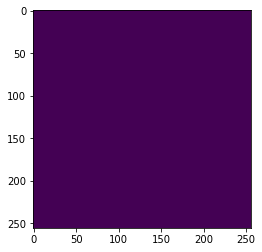

In [49]:
plt.imshow(plt.imread('./data/segmentation/testannot/0_predict.png')
)

In [ ]:
import cv2
import numpy as np
img2 = cv2.imread('./data/segmentation/aug/mask_31-7109572.png')
#img2=np.reshape(img2, img2.shape+(1,))

In [ ]:
plt.imshow(img2)

In [154]:
np.unique(img2)

array([0], dtype=uint8)